# Introduction: Manual Feature Engineering

이 노트북에서는 직접 피처를 만드는 방법에 대해 알아봅니다. 

이전 노트북에서는 모델을 구축하기 위해 application 데이터만 사용했습니다. 이 모델은 약 0.74의 점수를 얻었습니다. 점수를 더 받기 위해서는 다른 데이터프레임의 정보를 더 포함해야 합니다. 여기서는 bureau 및 bureau_balance 데이터의 활용에 대해 알아보겠습니다.

bureau: 고객이 이전에 다른 금융 기관에서 대출한 내용입니다. 이 대출은 각각 고유한 행이 있습니다.

bureau_balance: 이전 대출에 대한 월별 정보입니다. 매 월은 자체 행이 있습니다.
수동 피처 엔지니어링은 지루한 프로세스일 수 있으며 종종 도메인 전문지식에 의존합니다. 대출에 대해 제한된 도메인 지식을 가지고 있기 때문에, 가능한 한 많은 정보를 모을 것입니다. 따라서 모델은 우리가 직접 결정하는 것 보다 어떤 피처가 중요한지 알게 될 것입니다. 

기본적으로, 우리의 접근 방식은 가능한 많은 피처를 만든 다음 사용할 모델에 모든 피처를 제공하는 것입니다. 나중에 모델의 피처 중요도 또는 PCA와 같은 기술을 사용하여 기능 축소를 수행할 수 있습니다.


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

## Example: Counts of a client's previous loan
수동 피처 엔지니어링의 일반적인 프로세스를 설명하기 위해 먼저 다른 금융 기관에서 고객의 이전 대출 수를 파악할 수 있습니다. 

- groupby: 데이터프레임을 열 별로 그룹화합니다. 이 경우 고유한 고객인 SK_ID_CURR를 기준으로 그룹화합니다.
- agg: 열의 평균을 구하는 것과 같이 그룹화된 데이터에 대해 계산을 수행합니다. 함수를 직접 호출하거나(grouped_df.mean()) 변환 목록과 함께 agg 함수를 사용할 수 있습니다.(grouped_df.agg([mean,max,min,sum])
- merge: 집계된 통계를 적절한 고객과 일치시킵니다. 원래 트레이닝 데이터를 SK_ID_CURR의 계산된 통계와 병합해야 합니다. SK_ID_CURR에 상응하는 값이 없다면 널 값을 삽입합니다.

또한 딕셔너리로 이름을 바꿀 열을 지정하는 기능도 상당히 많이 사용합니다.

In [31]:
# Read in bureau
bureau = pd.read_csv('./input/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [32]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby("SK_ID_CURR", as_index=False)['SK_ID_BUREAU'].count().rename(columns={'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [33]:
# Join to the training dataframe
train = pd.read_csv('./input/application_train.csv')
train = train.merge(previous_loan_counts, on='SK_ID_CURR', how='left')

# Fill the missing values with 0
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Assesing Usefulness of New Variable with r value
새 변수가 유용한지 여부를 확인하기 위해 타겟 사이의 상관계수를 계산할 수 있습니다. 이 값은 두 변수 사이의 선형 관계의 강도를 측정하고 -1에서 +1까지의 범위를 측정합니다. r값은 새 변수의 유용도에 대한 최선의 척도는 아니지만 변수가 머신러닝 모델에 도움이 될지 여부에 대한 첫 번째 근사치를 제공할 수 있습니다. 타겟에 대한 변수의 r 값이 클 수록 더 많은 영향을 미칠 수 있습니다.

또한 KDE 그림을 사용하여 타겟과의 관계를 시각적으로 검사할 수도 있습니다.

### Kernel Density Estimate Plots
커널 밀도 추정치 그림에는 단일 변수의 분포가 표시됩니다. 범주형 변수의 값에 따라 분포의 차이를 확인하려면 범주에 따라 분포의 색을 다르게 지정할 수 있습니다. 예를 들어 , 타겟이 1인지 0인지에 따라 색상이 지정된 previous_loan_count의 커널 밀도 추정치를 표시할 수 있습니다. 

In [34]:
# Plots the distribution of a variable colored by value of the target
def kde_target(var_name, df):
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize= (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title('%s Distribution' % var_name)
    plt.legend()
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid = %0.4f' % avg_repaid)
    

랜덤 포레스트 및 gbm에 따라 가장 중요한 변수 중 하나로 밝혀진 EXT_SOURCE3 변수를 사용하여 함수를 테스트 해보겠습니다.

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid = 0.5460


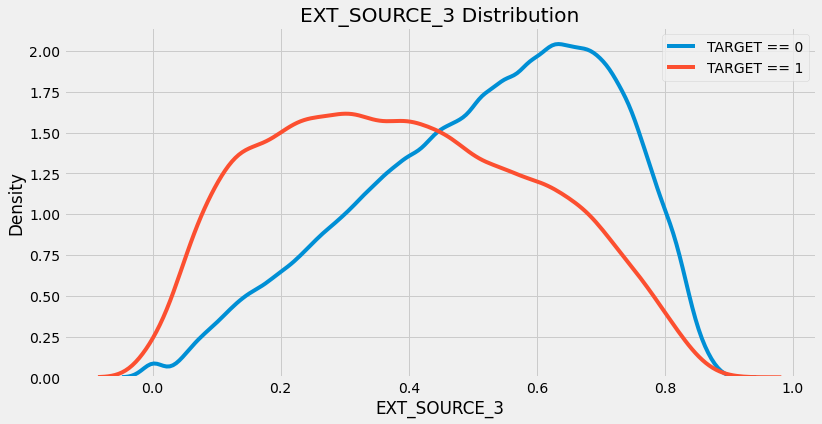

In [35]:
kde_target('EXT_SOURCE_3', train)

새로 만든 변수에 대해서도 테스트하겠습니다.

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid = 4.0000


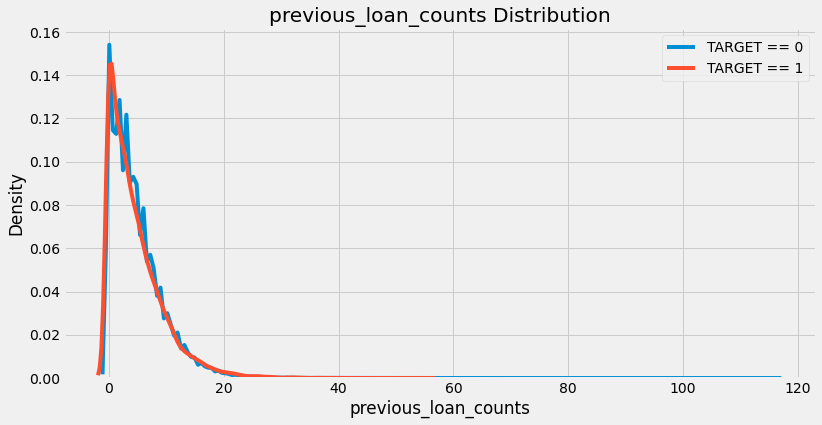

In [36]:
kde_target('previous_loan_counts', train)

이 변수로는 중요한지 여부를 알 수 없습니다. 상관 계수가 매우 약하고 분포에서 눈에 띄는 차이가 없습니다.

이제 bureau 데이터 프레임에서 몇 가지 변수를 더 만들어 보겠습니다. bureau 데이터 프레임에 있는 모든 숫자 열의 평균, 최소 및 최대값을 가져옵니다.

## Aggregating Numeric Columns
bureau 데이터 프레임의 숫자 정보를 설명하기 위해 통계를 계산할 수 있습니다. 이를 위해 고객 ID별 그룹화 및 트레이닝 데이터에 다시 병합합니다. agg 함수는 연산이 유효한 숫자열의 값만 계산합니다.

In [37]:
# Group by the client id, calculate aggreagtion statistics
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index=False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

각 열에 대한 새 이름을 만들겠습니다. 다음 코드는 이름에 stat을 추가하여 새 이름을 만듭니다. 데이터프레임에 다중 레벨 인덱스가 있기 때문에 단일 라벨 인덱스로 줄이겠습니다.

In [38]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [39]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


전에 했던 것처럼 트레이닝 데이터에 병합하겠습니다.

In [40]:
# Merge with the training data
train = train.merge(bureau_agg, on='SK_ID_CURR', how='left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


### Correlations of Aggregated Values with Target
새 값들의 상관 관계를 계산하겠습니다. 이러한 변수를 모형에 중요한 변수의 근사치로 사용할 수 있습니다.

In [41]:
# List of new correlations
new_corrs = []

# Iterate through the columns
for col in columns:
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])
    
    # Append the list as a tuple
    
    new_corrs.append((col, corr))

상관 관계를 크기별로 정렬하겠습니다. 이때 lambda 함수를 사용하겠습니다.

In [42]:
# Sort the correlations by the absolute value
# Make sure to reverse to put the largest values at the fron of list
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse=True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998122),
 ('bureau_DAYS_CREDIT_min', 0.0752482510301036),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968668),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984392113),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.05373489560102051),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758661),
 ('bureau_DAYS_CREDIT_max', 0.049782054639973095),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04885350261111589),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433483543),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.042863922470730176),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484684),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04140363535306004),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.036589634696329046),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.03428110992161599),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.030492306653325547)]

어떤 새 변수도 유의한 상관 관계를 갖지 않습니다. KDE 그림도 살펴보겠습니다. bureau_DAYS_CREDIT_mean, 절대값의 측면에서 타겟과 비교하겠습니다.

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid = -1067.0000


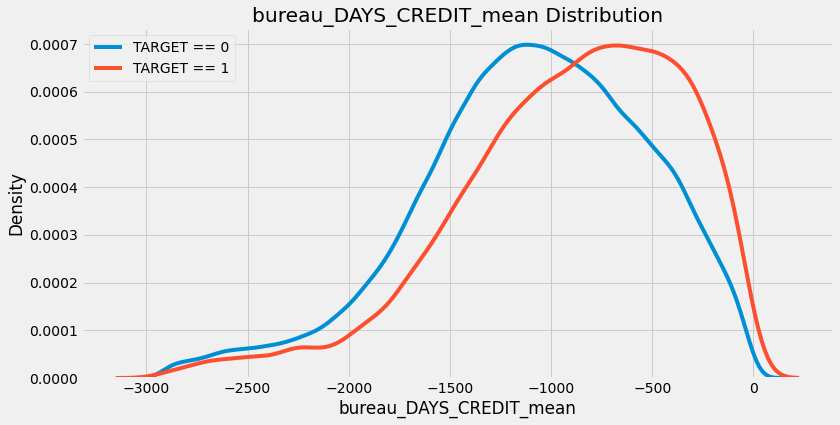

In [43]:
kde_target('bureau_DAYS_CREDIT_mean', train)

이 열의 정의는 '이전 대출을 현재 대출 전에 신청한 일 수' 입니다. 따라서 마이너스 수치가 크면 대출이 현재 대출 신청보다 더 이전임을 나타냅니다. 우리는 이 변수의 평균과 타겟 사이에 매우 약한 양의 상관관계가 있다고 봅니다. 이는 과거에 대출을 신청했던 고객들이 잠재적으로 대출을 상환할 가능성이 더 높다는 것을 의미합니다. 하지만 이렇게 약한 상관 관계에서는 노이즈일 가능성이 높습니다.

#### The Multiple Comparisons Problem
변수가 많을 때 일부 변수는 단순한 우연에 의해 상관 관계가 있을 것으로 예상합니다. 다중 비교로 알려진 문제입니다. 우리는 수백 가지의 피처를 만들 수 있고, 일부는 단순히 데이터의 무작위 노이즈 때문에 타겟과 상관관계가 있는 것으로 밝혀질 것입니다. 그 다음, 모델이 훈련할 떄 이러한 변수가 훈련 세트의 타겟과 관계가 있다고 생각하기 때문에 이러한 변수에 지나치게 적합할 수 있지만, 이것이 반드시 테스트 세트에 일반화 될 필요는 없습니다. 특징을 만들 때 고려해야 할 많은 것이 있습니다. 

## Function for Numeric Aggregations
이전의 모든 작업을 함수로 캡슐화하겠습니다. 이를 통해 모든 데이터프레임에서 숫자 열에 대한 집계 통계를 계산할 수 있습니다.

In [44]:
def agg_numeric(df, group_var, df_name):
    """데이터 프레임의 모든 숫자 값을 집계함. 그룹화 변수의 각 인스턴스에 대한 피        처를 작성하는 데 사용됩니다.
    
    Parameters
    ----------
        df (dataframe):
            계산에 사용될 데이터프레임
        group_var (string):
            그룹화 할 변수
        df_name (string):
            열의 이름 재정의할 변수
    
    Return
    ----------
        agg (dataframe):
            모든 숫자형 열에 대한 통계가 집계된 데이터프레임.
            그룹화 된 변수의 각 인스턴스는 통계정보를 포함함.
            이름 재정의는 추후 진행 예정
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns=col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids
    
    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
    
    # Need to create new column names
    columns = [group_var]
    
    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the groupiong variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
        
    agg.columns = columns
    return agg

In [45]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = "SK_ID_CURR", df_name = 'bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


이 함수를 다른 데이터 프레임에 대한 숫자통계를 계산하는 데 재사용할 수 있을 것입니다. 함수를 사용하면 일관된 결과를 얻을 수 있고 해야할 일의 양을 줄일 수 있습니다.

### Correlation Function
타겟과의 상관관계를 계산하는 코드를 함수로 만들 수도 있습니다.

In [46]:
# Function to calculate correlations with the target for a dataframe
def target_corrs(df):
    
    # List of correlations
    corrs = []
    
    # Iterate through the columns
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])
            
            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse=True)
    
    return corrs

## Caregorical Variable
이제 숫자 열에서 범주형 열로 이동합니다. 이들은 이산형으로 평균 및 최대값과 같은 통계량은 계산할 수 없습니다. 대신, 각 범주형 변수 내에서 각 범주의 값의 빈도등을 계산하는데 의존합니다.

주로 데이터를 인코딩합니다. 원 핫 인코딩을 사용하겠습니다.

In [47]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [48]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

sum 열은 관련 고객에 대한 해당 범주의 개수를 나타내고 평균은 정규화된 카운트를 나타냅니다. 원핫인코딩을 사용하면 이러한 수치를 쉽게 계산할 수 있습니다.

이전과 유사한 함수를 사용하여 열의 이름을 바꿀 수 있습니다. 다시한번 멀티 레벨의 인덱스를 다뤄야합니다. 우리는 범주 값에 추가된 범주형 변수의 이름인 첫 번째 수준(레벨0)을 반복합니다. 그런 다음 각 고객에 대해 계산된 통계를 반복합니다. 통계가 추가된 레벨 0 이름으로 열의 이름을 변경합니다. 예를 들어 CREDIT_ACTIVE_Active를 레벨 0으로 하고 합계를 레벨 1로 하는 열은 CREDIT_ACTIVE_Active_count가 됩니다.

In [49]:
categorical_grouped.columns.levels[0][:10]

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan'],
      dtype='object')

In [50]:
categorical_grouped.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [51]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for variable and stat
            columns.append('%s_%s' % (var, stat))
            
# Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


sum 열이 카운트를 기록하고, mean 열이 정규화된 카운트를 기록합니다. 

이를 트레이닝 데이터에 병합하겠습니다.

In [52]:
train = train.merge(categorical_grouped, left_on='SK_ID_CURR', right_index=True, how='left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
train.iloc[:10, 123:]

,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,8.0,-874.000000,-103.0,-1437.0,-6992.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,-1400.750000,-606.0,-2586.0,-5603.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,-867.000000,-408.0,-1326.0,-1734.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,-1149.000000,-1149.0,-1149.0,-1149.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,-757.333333,-78.0,-1097.0,-2272.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,18.0,-1271.500000,-239.0,-2882.0,-22887.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,-1939.500000,-1138.0,-2741.0,-3879.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,-1773.000000,-1309.0,-2508.0,-7092.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Function to Handle Categorical Variables
코드를 보다 효율적으로 만들기 위해 이제 범주형 변수를 처리하는 함수를 작성할 수 있습니다. 데이터 프레임과 그룹화 변수를 수용한다는 점에서 agg_numeric 함수와 동일한 형식을 취합니다.그런 다음 데이터 프레임의 모든 범주형 변수에 대한 각 범주의 카운트 및 정규화된 카운트를 계산합니다.

In [54]:
def count_categorical(df, group_var, df_name):
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))
    
    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]
    
    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
            
    categorical.columns = column_names
    
    return categorical

In [55]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name='bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### Applying Operationgs to another dataframe
이제 bureau balance 데이터프레임을 살펴보겠습니다. 이 데이터프레임에는 각 고객의 다른 금융기관과의 이전 대출에 대한 월별 정보가 있습니다. 이 데이터 프레임을 고객 ID인 SK_ID_CURR로 그룹화하는 대신 이전 대출의 ID인 SK_ID_BUREAU로 그룹화할 것입니다. 이렇게 하면 각 대출에 대해 데이터 프레임의 행이 하나씩 제공됩니다. 그런 다음 SK_ID_CURR로 그룹화하고 각 고객에 대해 집계를 계산합니다. 최종 결과는 각 고객에 대해 하나의 행이 있는 데이터프레임으로, 대출에 대한 통계가 계산됩니다.

In [56]:
# Read in bureau balance
bureau_balance = pd.read_csv('./input/bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


먼저 각 대출의 상태에 대한 카운트를 계산하겠습니다. 우리는 이에 대한 함수를 이미 작성했습니다.

In [57]:
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


MONTH_BALANCE 열에 '지원날짜 대비 잔액 월'이 있습니다. 이는 숫자 변수로써 반드시 중요한 것은 아닐 수 있으며, 향후 작업에서는 이를 시간 변수로 간주하고자 할 수 있습니다. 현재로서는 이전과 동일한 집계 통계를 계산할 수 있습니다.

In [58]:
# Calculate value count statistics for each 'SK_ID_CURR'
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


위의 데이터프레임은 각 대출에 대해 계산한 것입니다. 이제 각 고객별로 데이터를 집계해야 합니다. 먼저 데이터프레임을 병합한 뒤 재집계합니다. 이번에는 SK_ID_CURR로 그룹화합니다.

In [59]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index=True, left_on = 'SK_ID_BUREAU', how='outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on='SK_ID_BUREAU', how='left')

bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [60]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns=['SK_ID_BUREAU']), group_var='SK_ID_CURR', df_name='client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.0,1.018182


bureau_balance 데이터프레임에 대해 요약하면 다음과 같습니다.
1. 각 대출별로 계산된 숫자 통계 그룹화
2. 대출에 따른 각 범주형 변수 그룹의 값 빈도
3. 대출에 대한 통계 및 값 카운트 병합
4. 고객 ID별로 그룹화된 숫자 통계

최종 결과 데이터 프레임은 각 고객에 대해 하나의 행이 있으며, 월별 잔액 정보를 사용하여 모든 대출에 대해 계산된 통계가 있습니다.

이러한 변수 중 일부는 약간 혼란스럽기 때문에 몇 가지 설명을 해보겠습니다.
- client_bureau_balance_MONTHS_BALANCE_mean_mean: 각 대출의 평균값을 계산합니다. 그런 다음 각 고객의 모든 대출에 대한 평균을 계산합니다.
- client_bureau_balance_STATUS_X_count_norm_sum: 각 대출에서 STATUS==X 발생 횟수를 대출에 대한 총 STATUS 값 수로 나눈 값을 계산합니다. 그런 다음 각 클라이언트에 대해 각 대출에 대한 값을 합합니다.

모든 변수가 하나의 데이터 프레임에 있을 때까지 상관 관계 계산을 연기하겠습니다.

## Putting the Functions Together
우리는 이제 다른 기관의 이전 대출과 이러한 대출에 대한 월별 지급 정보를 받아 주요 교육 데이터 프레임에 넣을 수 있는 모든 자료를 준비했습니다. 모든 변수를 다시 설정한 다음 우리가 만든 함수를 사용하여 처음부터 다시 설정해보겠습니다.

In [61]:
# Free up memory by deleting old objects
import gc
gc.enable()
del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

165734

In [62]:
# Read in new copies of all the dataframes
train = pd.read_csv('./input/application_train.csv')
bureau = pd.read_csv('./input/bureau.csv')
bureau_balance = pd.read_csv('./input/bureau_balance.csv')

In [63]:
### Counts of Bureau Dataframe
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name='bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### Aggregated Stats of Bureau Dataframe


In [64]:
bureau_agg = agg_numeric(bureau.drop(columns=['SK_ID_BUREAU']), group_var='SK_ID_CURR', df_name='bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


### Value counts of Bureau Balance dataframe by loan

In [65]:
bureau_balance_counts = count_categorical(bureau_balance, group_var='SK_ID_BUREAU', df_name='bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


### Aggregated stats of Bureau Balance dataframe by loan

In [66]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


### Aggregate Stats of Bureau Balance by client

In [67]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index=True, left_on = 'SK_ID_BUREAU', how='outer')
# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on='SK_ID_BUREAU', how='left')
# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns=['SK_ID_BUREAU']), group_var='SK_ID_CURR', df_name='client')

## Insert Computed Features into Training Data

In [68]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [69]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on='SK_ID_CURR', how='left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on='SK_ID_CURR', how='left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on='SK_ID_CURR', how='left')

In [72]:
new_features = list(train.columns)
print('병합 후 피처 수:', len(new_features))

병합 후 피처 수: 333


## Feature Engineering Outcomes
이제 우리가 만든 변수들을 살펴보려 합니다. 결측값의 백분율, 변수와 타겟의 상관 관계, 변수와 다른 변수의 상관관계도 살펴볼 수 있습니다. 변수 간의 상관 관계는 선형 변수, 즉 서로 높은 상관 관계를 갖는 변수를 보여줄 수 있습니다. 두 변수가 종종 중복되기 때문에 한 쌍의 선형 변수에서 하나를 제거하려고 합니다. 또한 결측값의 백분율을 사용하여 대부분의 값이 존재하지 않는 피처를 제거할 수 있습니다. 피처 수를 줄이면 모델이 교육 중에 학습하고 테스트 데이터에 대해 더 잘 일반화할 수 있기 때문에 피처 선택은 앞으로 중요한 초점이 될 것입니다. 차원성의 저주(curse of dimensionality)는 너무 많은 피처(차원의 너무 높음)으로 인해 발생하는 문제에 주어진 이름입니다. 변수가 많아지면 타겟과의 관계를 학습하는데 필요한 데이터의 수가 기하급수적으로 증가합니다.

피처 선택은 모델이 테스트 세트에 대해 더 잘 학습하고 일반화하도록 돕기 위해 변수를 제거하는 과정 쓸모 없는/중복 변수를 제거하는 동시에 유용한 변수를 보존하는 것이 목표입니다. 이 프로세스에 사용할 수 있는 도구는 여러 가지가 있지만, 이 노트북에서는 결측값의 비율이 높은 열과 서로 상관 관계가 높은 변수를 제거하는 작업을 계속할 것입니다. 나중에 Gradient Boosting Machine 또는 Random Forest와 같은 모델에서 반환되는 피처 중요도를 사용하여 피처 선택을 수행할 수 있습니다.

## Missing Values
중요한 고려 사항은 데이터프레임에 결측값이 있다는 것입니다. 결측값이 너무 많은 열을 삭제해야 할 수 있습니다.

In [73]:
# Function to calculate missing values by column 
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns 
    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0: 'Missing Values', 1: '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print('선택된 데이터프레임은 {}개의 열을 가짐.\n {}개의 열이 결측치를 가짐.'.format(df.shape[1], mis_val_table_ren_columns.shape[0]))
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [74]:
missing_train = missing_values_table(train)
missing_train.head(10)

선택된 데이터프레임은 333개의 열을 가짐.
 278개의 열이 결측치를 가짐.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_mean,215280,70.0
client_bureau_balance_STATUS_3_count_norm_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_max,215280,70.0


결측값의 비율이 높은 열이 여러 개 있습니다. 결측값을 제거하기 위한 잘 설정된 임계값이 없으며 최선의 방법은 문제에 따라 다릅니다. 여기서 피처 수를 줄이기 위해 결측값이 90% 이상인 훈련 또는 시험 데이터의 열을 모두 제거하겠습니다.

In [75]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

0

훈련 데이터에는 90%이상의 결측값을 갖는 열이 없습니다. 테스트 데이터에서도 결측값 백분율을 찾을 수 있습니다. 그런 다음 테스트 데이터에서 결측값이 90% 이상인 열을 제거합니다. 이제 테스트 데이터를 읽고, 동일한 작업을 수행하고, 테스트 데이터의 결측값을 살펴보겠습니다. 우리는 이미 모든 카운트와 집계 통계를 계산했기 때문에 테스트 데이터만 적절한 데이터와 병합하면 됩니다.

## Calculate Information for Testing Data

In [76]:
# Read in the test dataframe
test = pd.read_csv('./input/application_test.csv')

# Merge with the values counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how='left')

# Merge with the stats bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how='left')

# Merge with the values counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how='left')


In [77]:
print('테스트 데이터 shape', test.shape)

테스트 데이터 shape (48744, 332)


테스트 및 교육 데이터 프레임을 정렬해야 합니다. 즉, 열이 정확하게 일치하도록 열을 일치시킵니다. 이것은 문제가 되지 않지만, 우리가 원핫 인코딩 변수를 사용할 때, 우리는 데이터 프레임이 동일한 열을 가지도록 정렬해야 합니다.

In [78]:
train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join='inner', axis=1)

train['TARGET'] = train_labels

In [79]:
print(train.shape)
print(test.shape)

(307511, 333)
(48744, 332)


이제 데이터 프레임에 동일한 열이 있습니다(교육 데이터의 TARGET 열은 제외). 이는 교육 및 테스트 데이터 프레임 모두에서 동일한 열을 봐야 하는 머신 러닝 모델에서 이를 사용할 수 있음을 의미합니다.

이제 삭제해야 할 열을 파악할 수 있도록 검사 데이터에서 결측값의 백분율을 살펴보겠습니다.

In [81]:
missing_test = missing_values_table(test)
missing_test.head(10)

선택된 데이터프레임은 332개의 열을 가짐.
 275개의 열이 결측치를 가짐.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [82]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

0

결측값이 90% 이상인 열이 없기 때문에 열을 제거하지 못했습니다. 차원 축소를 위해 다른 피처 선택 방법을 적용해야 할 수 있습니다.

In [83]:
train.to_csv('train_bureau_raw.csv', index=False)
test.to_csv('test_bureau_raw.csv', index=False)

## Correlations
먼저 변수와 타겟의 상관 관계를 살펴보겠습니다. 생성된 변수는 어떤 변수라도 (application 데이터에서) 교육 데이터에 이미 있는 변수보다 더 큰 상관 관계를 가지고 있음을 알 수 있습니다.

In [84]:
# Calculate all correlations in dataframe
corrs = train.corr()

In [85]:
corrs = corrs.sort_values('TARGET', ascending=False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [86]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
client_bureau_balance_MONTHS_BALANCE_count_min,-0.048224
client_bureau_balance_STATUS_C_count_norm_mean,-0.055936
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


타겟과 상관 관계가 가장 높은 변수는 우리가 생성한 변수입니다. 그러나 변수가 상관관계가 있다고 해서 유용하다는 의미는 아니며, 수백 개의 새로운 변수를 생성한다면 일부는 단순히 무작위 노이즈 때문에 타겟과 상관관계가 있다는 사실을 기억해야 합니다.

새로 생성된 변수 중 몇 가지가 유용할 수 있습니다. 변수의 "유용성"을 평가하기 위해 모델이 반환하는 피처 중요도에 대해 알아보겠습니다. 호기심을 위해(그리고 이미 함수를 작성했기 때문에) 새로 생성된 변수 중 두 개의 kde 그림을 만들어 보겠습니다.

The correlation between client_bureau_balance_MONTHS_BALANCE_count_mean and the TARGET is -0.0802
Median value for loan that was not repaid = 19.3333
Median value for loan that was repaid = 25.1429


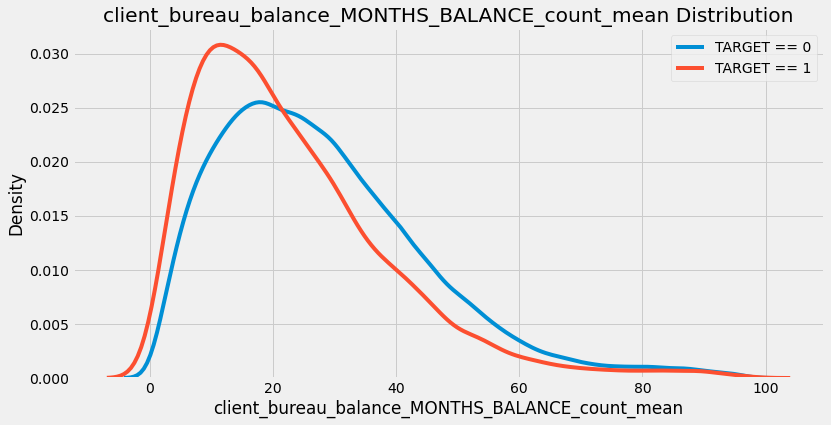

In [90]:
kde_target(var_name='client_bureau_balance_MONTHS_BALANCE_count_mean', df=train)

이 변수는 각 클라이언트의 대출당 월 평균 레코드 수를 나타냅니다. 예를 들어, 고객이 월별 데이터에 3, 4, 5개의 레코드가 있는 세 개의 이전 대출이 있는 경우, 이 변수의 값은 4가 됩니다. 분포를 보면 대출당 월평균 기록이 많은 고객은 대출금을 상환할 가능성이 더 높습니다. 이전의 신용 기록이 더 많은 고객들이 일반적으로 대출금을 상환할 가능성이 더 높다는 것을 나타낼 수 있습니다.

The correlation between bureau_CREDIT_ACTIVE_Active_count_norm and the TARGET is 0.0774
Median value for loan that was not repaid = 0.5000
Median value for loan that was repaid = 0.3636


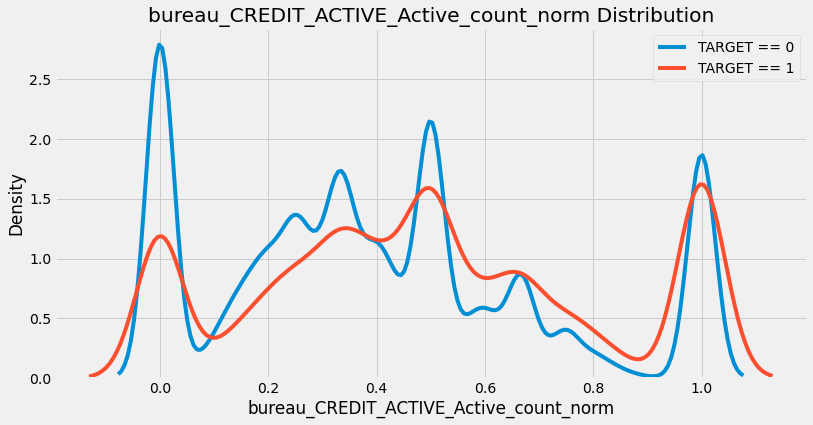

In [91]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Active_count_norm', df=train)

이 분포는 사방에 널려 있습니다. 이 변수는 CREADIT_ACTIVE 값이 Active인 이전 대출 수를 클라이언트에 대한 이전 대출 수로 나눈 값을 나타냅니다. 여기의 상관관계가 너무 약해서 결론을 내려서는 안 될 것 같습니다.


### Collineart Variables
변수와 타겟의 상관 관계뿐만 아니라 각 변수의 상관 관계도 계산할 수 있습니다. 이를 통해 데이터에서 제거해야 할 높은 선형 변수가 있는지 확인할 수 있습니다.

다른 변수와 0.8 이상의 상관 관계를 갖는 변수를 살펴보겠습니다.

In [92]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated varaibles
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

상관 관계가 높은 각 변수 쌍에 대해 한 변수만 제거하려고 합니다. 다음 코드는 각 쌍 중 하나만 추가하여 제거할 변수 집합을 만듭니다.

In [93]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
    
cols_to_remove = list(set(cols_to_remove))
print('삭제할 열의 수:', len(cols_to_remove))

삭제할 열의 수: 134


교육 데이터 세트와 테스트 데이터 세트 모두에서 이러한 열을 제거할 수 있습니다. 이러한 변수를 제거한 후 성능을 이러한 변수(아까 저장한 raw csv 파일)를 유지하는 성능으로 비교해야 합니다.

In [94]:
train_corrs_removed = train.drop(columns=cols_to_remove)
test_corrs_removed = test.drop(columns=cols_to_remove)

print("제거 후 train Corrs shape", train_corrs_removed.shape)
print("제거 후 test Corrs shape", test_corrs_removed.shape)

제거 후 train Corrs shape (307511, 199)
제거 후 test Corrs shape (48744, 198)


In [95]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index=False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index=False)